## Final validation

In [6]:
import multirex as mrex
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import sys
import pandas as pd
from tqdm import tqdm

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker


from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import  ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score
from sklearn.metrics import hamming_loss, accuracy_score


## import models

In [7]:
## load rf model

import joblib
## load rf per molecule
rf_CH4 = joblib.load("CH4_rf.joblib")
rf_O3 = joblib.load("O3_rf.joblib")
rf_H2O = joblib.load("H2O_rf.joblib")

rf = joblib.load("MC_rf.joblib")

rf_inter = joblib.load("BC_rf.joblib")


In [8]:
def normalize_min_max_by_row(df):
    min_by_row = df.min(axis=1)
    max_by_row = df.max(axis=1)
    
    range_by_row = max_by_row - min_by_row
    normalized = (df.sub(min_by_row, axis=0)).div(range_by_row, axis=0)
    return normalized

import ast
def string_to_list(string):
    return ast.literal_eval(string)

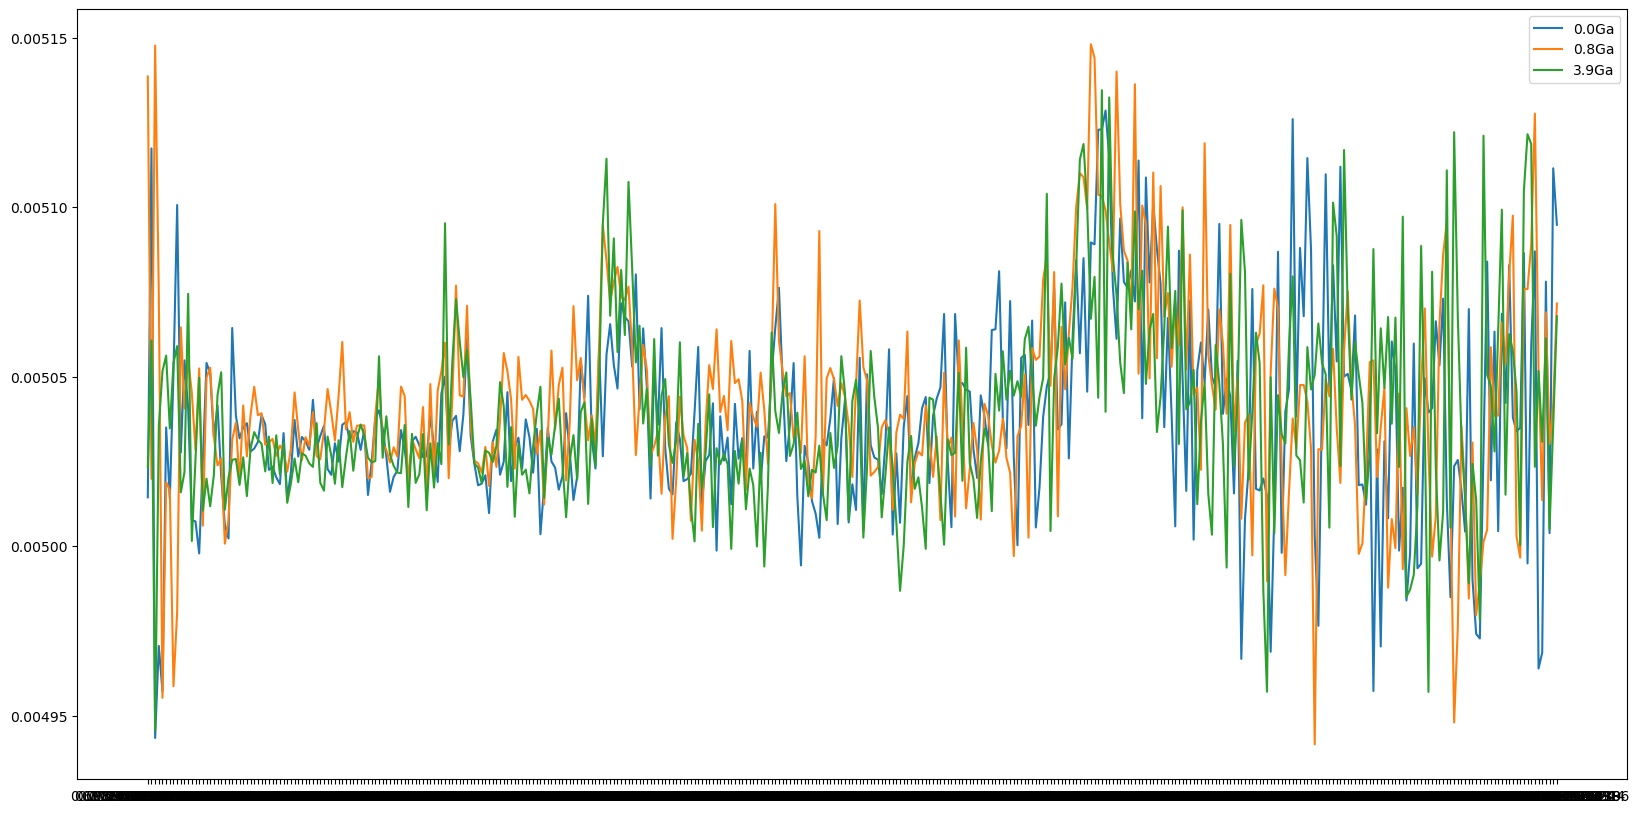

In [9]:
plt.figure(figsize=(20, 10)) 
plt.plot(pd.read_csv("Earth/E_0.0Ga_100_Transits.csv").iloc[0], label="100 Transits")
plt.title("Earth Spectrum at 0.0 Ga Ago")
plt.legend()


## 0.0 Ago



c:\Users\santi\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
c:\Users\santi\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
c:\Users\santi\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
c:\Users\santi\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\santi\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0

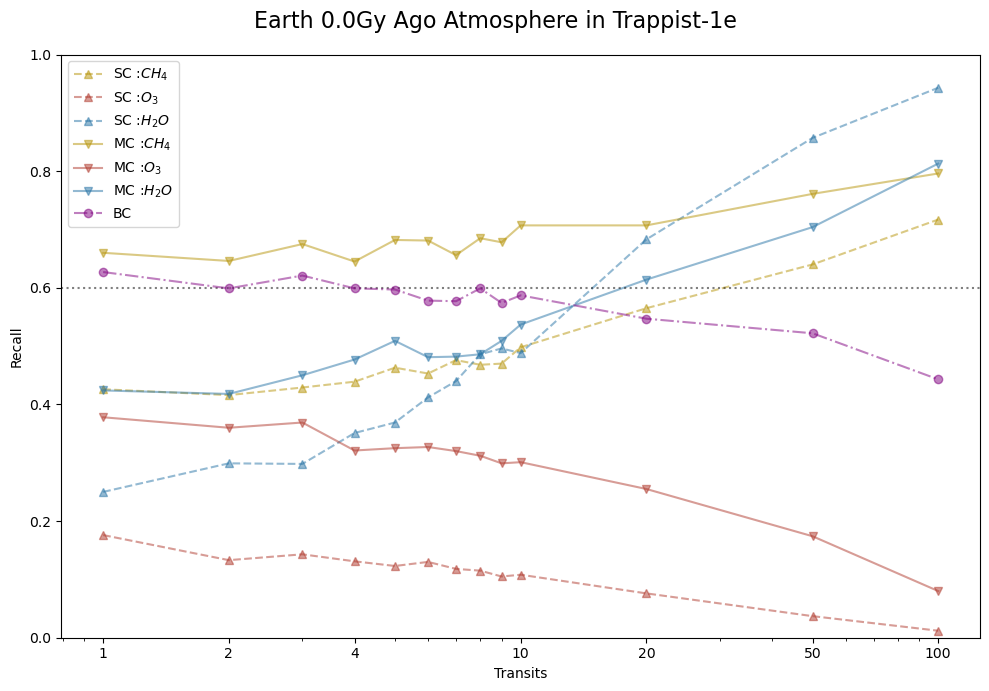

In [12]:
mol_SNR_scores = dict(
    SNR=[],
    f1= [ [] , [] , [] ],
    recall_score = [ [] , [] , [] ],
    precision_score= [ [] , [] , [] ],
    accuracy= [ [] , [] , [] ],
    min_mix_ratio= [ [] , [] , [] ],
    TNR = [ [] , [] , [] ], #True Negative Rate
) 

global_SNR_scores = dict(
    SNR=[],
    f1=[],
    recall=[],
    precision=[],
    perfect_match=[],
    hamming_loss=[],
    TNR=[], # True negative rate   
)

F1_mol_SNR_scores = dict(
    SNR=[],
    f1= [ [] , [] , [] ],
    recall_score = [ [] , [] , [] ],
    precision_score= [ [] , [] , [] ],
    accuracy= [ [] , [] , [] ],
    min_mix_ratio= [ [] , [] , [] ],
    TNR = [ [] , [] , [] ], #True Negative Rate
) 

F1_global_SNR_scores = dict(
    SNR=[],
    f1=[],
    recall=[],
    precision=[],
    perfect_match=[],
    hamming_loss=[],
    TNR=[], # True negative rate   
)

n_transits= [1,2,3,4,5,6,7,8,9,10,20,50,100
             ]

interesting_recall = []

for i, n_transit in enumerate(n_transits):
    n= n_transit
    SNR_test_df = pd.read_csv(f"Earth/E_0.0Ga_{n}_transits.csv")
    SNR_test_df['label'] = 1
    SNR_test_df['label'] = SNR_test_df['label'].apply(lambda x: [1,1,1])
    cols = list(SNR_test_df.columns)
    cols = [cols[-1]] + cols[:-1]
    SNR_test_df = SNR_test_df[cols]
    
    SNR_test_df.iloc[:,1:] = normalize_min_max_by_row(SNR_test_df.iloc[:,1:])
    SNR_X_test = SNR_test_df.iloc[:,1:]
    SNR_X_test = SNR_X_test.values
    SNR_test_CH4 = np.array([item[0] for item in SNR_test_df["label"]]) 
    SNR_test_O3 = np.array([item[1] for item in SNR_test_df["label"]])
    SNR_test_H2O = np.array([item[2] for item in SNR_test_df["label"]])

    SNR_test_df["CH4 label"] = SNR_test_CH4
    SNR_test_df["O3 label"] = SNR_test_O3
    SNR_test_df["H2O label"] = SNR_test_H2O

    CH4_probabilities= rf_CH4.predict_proba(SNR_X_test)[:,1]
    O3_probabilities= rf_O3.predict_proba(SNR_X_test)[:,1]
    H2O_probabilities= rf_H2O.predict_proba(SNR_X_test)[:,1]
    #Asignar etiquetas basadas en el umbral ajustado
    CH4_threshold = 0.4
    O3_threshold = 0.33
    H2O_threshold = 0.36
    
    CH4_y_pred = (CH4_probabilities > CH4_threshold).astype(int)
    O3_y_pred = (O3_probabilities > O3_threshold).astype(int)
    H2O_y_pred = (H2O_probabilities > H2O_threshold).astype(int)
    
    # Asignar etiquetas y puntuaciones a las predicciones
    SNR_test_df["CH4 3F pred"] = CH4_y_pred
    SNR_test_df["CH4 score"] = CH4_probabilities
    SNR_test_df["O3 3F pred"] = O3_y_pred
    SNR_test_df["O3 score"] = O3_probabilities
    SNR_test_df["H2O 3F pred"] = H2O_y_pred
    SNR_test_df["H2O score"] = H2O_probabilities
    
    ## Global scores
    global_SNR_scores["SNR"].append(SNR)
    global_SNR_scores["f1"].append(f1_score(SNR_test_df[["CH4 label", "O3 label", "H2O label"]],
                SNR_test_df[["CH4 3F pred", "O3 3F pred", "H2O 3F pred"]], average="macro"))
    global_SNR_scores["recall"].append(recall_score(SNR_test_df[["CH4 label", "O3 label", "H2O label"]],
                    SNR_test_df[["CH4 3F pred", "O3 3F pred", "H2O 3F pred"]], average="macro"))
    global_SNR_scores["precision"].append(precision_score(SNR_test_df[["CH4 label", "O3 label", "H2O label"]],
                    SNR_test_df[["CH4 3F pred", "O3 3F pred", "H2O 3F pred"]], average="macro"))
    global_SNR_scores["perfect_match"].append(accuracy_score(SNR_test_df[["CH4 label", "O3 label", "H2O label"]],
                        SNR_test_df[["CH4 3F pred", "O3 3F pred", "H2O 3F pred"]]))
    global_SNR_scores["hamming_loss"].append(hamming_loss(SNR_test_df[["CH4 label", "O3 label", "H2O label"]],
                    SNR_test_df[["CH4 3F pred", "O3 3F pred", "H2O 3F pred"]]))
    global_SNR_scores["TNR"].append(recall_score(SNR_test_df[["CH4 label", "O3 label", "H2O label"]],
                        SNR_test_df[["CH4 3F pred", "O3 3F pred", "H2O 3F pred"]], average="macro",
                        labels=[0]))
    
    ## mol scores
    mol_SNR_scores["SNR"].append(SNR)
    mol_SNR_scores["f1"][0].append(f1_score(SNR_test_df["CH4 label"],SNR_test_df["CH4 3F pred"]))
    mol_SNR_scores["f1"][1].append(f1_score(SNR_test_df["O3 label"],SNR_test_df["O3 3F pred"]))
    mol_SNR_scores["f1"][2].append(f1_score(SNR_test_df["H2O label"],SNR_test_df["H2O 3F pred"]))
    
    mol_SNR_scores["recall_score"][0].append(recall_score(SNR_test_df["CH4 label"],SNR_test_df["CH4 3F pred"]))
    mol_SNR_scores["recall_score"][1].append(recall_score(SNR_test_df["O3 label"],SNR_test_df["O3 3F pred"]))
    mol_SNR_scores["recall_score"][2].append(recall_score(SNR_test_df["H2O label"],SNR_test_df["H2O 3F pred"]))
    
    mol_SNR_scores["precision_score"][0].append(precision_score(SNR_test_df["CH4 label"],SNR_test_df["CH4 3F pred"]))
    mol_SNR_scores["precision_score"][1].append(precision_score(SNR_test_df["O3 label"],SNR_test_df["O3 3F pred"]))
    mol_SNR_scores["precision_score"][2].append(precision_score(SNR_test_df["H2O label"],SNR_test_df["H2O 3F pred"]))
    
    mol_SNR_scores["accuracy"][0].append(accuracy_score(SNR_test_df["CH4 label"],SNR_test_df["CH4 3F pred"]))
    mol_SNR_scores["accuracy"][1].append(accuracy_score(SNR_test_df["O3 label"],SNR_test_df["O3 3F pred"]))
    mol_SNR_scores["accuracy"][2].append(accuracy_score(SNR_test_df["H2O label"],SNR_test_df["H2O 3F pred"]))
    
    mol_SNR_scores["TNR"][0].append(recall_score(SNR_test_df["CH4 label"],SNR_test_df["CH4 3F pred"], pos_label=0))
    mol_SNR_scores["TNR"][1].append(recall_score(SNR_test_df["O3 label"],SNR_test_df["O3 3F pred"], pos_label=0))
    mol_SNR_scores["TNR"][2].append(recall_score(SNR_test_df["H2O label"],SNR_test_df["H2O 3F pred"], pos_label=0))
    
    ## 1F
    CH4_probabilities= rf.predict_proba(SNR_X_test)[0][:,1]
    O3_probabilities= rf.predict_proba(SNR_X_test)[1][:,1]
    H2O_probabilities= rf.predict_proba(SNR_X_test)[2][:,1]
 
    CH4_threshold = 0.49
    O3_threshold = 0.45
    H2O_threshold = 0.5
    
    CH4_y_pred = (CH4_probabilities > CH4_threshold).astype(int)
    O3_y_pred = (O3_probabilities > O3_threshold).astype(int)
    H2O_y_pred = (H2O_probabilities > H2O_threshold).astype(int)
    
    SNR_test_df["CH4 1F pred"] = CH4_y_pred    
    SNR_test_df["O3 1F pred"] = O3_y_pred    
    SNR_test_df["H2O 1F pred"] = H2O_y_pred
    
    F1_global_SNR_scores["SNR"].append(SNR)
    F1_global_SNR_scores["f1"].append(f1_score(SNR_test_df[["CH4 label", "O3 label", "H2O label"]],
                    SNR_test_df[["CH4 1F pred", "O3 1F pred", "H2O 1F pred"]], average="macro"))
    F1_global_SNR_scores["recall"].append(recall_score(SNR_test_df[["CH4 label", "O3 label", "H2O label"]],
                        SNR_test_df[["CH4 1F pred", "O3 1F pred", "H2O 1F pred"]], average="macro"))
    F1_global_SNR_scores["precision"].append(precision_score(SNR_test_df[["CH4 label", "O3 label", "H2O label"]],
                            SNR_test_df[["CH4 1F pred", "O3 1F pred", "H2O 1F pred"]], average="macro"))
    F1_global_SNR_scores["perfect_match"].append(accuracy_score(SNR_test_df[["CH4 label", "O3 label", "H2O label"]],
                                SNR_test_df[["CH4 1F pred", "O3 1F pred", "H2O 1F pred"]]))
    
    F1_global_SNR_scores["hamming_loss"].append(hamming_loss(SNR_test_df[["CH4 label", "O3 label", "H2O label"]],
                            SNR_test_df[["CH4 1F pred", "O3 1F pred", "H2O 1F pred"]]))
    F1_global_SNR_scores["TNR"].append(recall_score(SNR_test_df[["CH4 label", "O3 label", "H2O label"]],
                            SNR_test_df[["CH4 1F pred", "O3 1F pred", "H2O 1F pred"]], average="macro",
                            labels=[0]))
    
    F1_mol_SNR_scores["SNR"].append(SNR)
    F1_mol_SNR_scores["f1"][0].append(f1_score(SNR_test_df["CH4 label"],SNR_test_df["CH4 1F pred"]))
    F1_mol_SNR_scores["f1"][1].append(f1_score(SNR_test_df["O3 label"],SNR_test_df["O3 1F pred"]))
    F1_mol_SNR_scores["f1"][2].append(f1_score(SNR_test_df["H2O label"],SNR_test_df["H2O 1F pred"]))
    
    F1_mol_SNR_scores["recall_score"][0].append(recall_score(SNR_test_df["CH4 label"],SNR_test_df["CH4 1F pred"]))
    F1_mol_SNR_scores["recall_score"][1].append(recall_score(SNR_test_df["O3 label"],SNR_test_df["O3 1F pred"]))
    F1_mol_SNR_scores["recall_score"][2].append(recall_score(SNR_test_df["H2O label"],SNR_test_df["H2O 1F pred"]))
    
    F1_mol_SNR_scores["precision_score"][0].append(precision_score(SNR_test_df["CH4 label"],SNR_test_df["CH4 1F pred"]))
    F1_mol_SNR_scores["precision_score"][1].append(precision_score(SNR_test_df["O3 label"],SNR_test_df["O3 1F pred"]))
    F1_mol_SNR_scores["precision_score"][2].append(precision_score(SNR_test_df["H2O label"],SNR_test_df["H2O 1F pred"]))
    
    F1_mol_SNR_scores["accuracy"][0].append(accuracy_score(SNR_test_df["CH4 label"],SNR_test_df["CH4 1F pred"]))
    F1_mol_SNR_scores["accuracy"][1].append(accuracy_score(SNR_test_df["O3 label"],SNR_test_df["O3 1F pred"]))
    F1_mol_SNR_scores["accuracy"][2].append(accuracy_score(SNR_test_df["H2O label"],SNR_test_df["H2O 1F pred"]))
    
    F1_mol_SNR_scores["TNR"][0].append(recall_score(SNR_test_df["CH4 label"],SNR_test_df["CH4 1F pred"], pos_label=0))
    F1_mol_SNR_scores["TNR"][1].append(recall_score(SNR_test_df["O3 label"],SNR_test_df["O3 1F pred"], pos_label=0))
    F1_mol_SNR_scores["TNR"][2].append(recall_score(SNR_test_df["H2O label"],SNR_test_df["H2O 1F pred"], pos_label=0))
       
    score = rf_inter.predict_proba(SNR_X_test)[:,1]
    inter_predic = (score > 0.4).astype(int)
    interesting_recall.append(recall_score(SNR_test_df["CH4 label"], inter_predic))
    
 
## plot molecule metrics
fig, ax = plt.subplots(figsize=(10,7))


ax.plot(mol_SNR_scores["SNR"], mol_SNR_scores["recall_score"][0],
        label="SC :$CH_4$", color= "#B7950B",
        linestyle="--", marker="^",alpha=0.5)
ax.plot(mol_SNR_scores["SNR"], mol_SNR_scores["recall_score"][1],
        label="SC :$O_3$", color= "#B03A2E", 
        linestyle="--", marker="^",alpha=0.5)
ax.plot(mol_SNR_scores["SNR"], mol_SNR_scores["recall_score"][2],
        label="SC :$H_2O$", color= "#2874A6",
        linestyle="--", marker="^",alpha=0.5)
ax.plot(F1_mol_SNR_scores["SNR"], F1_mol_SNR_scores["recall_score"][0],
        label="MC :$CH_4$", color= "#B7950B",
        marker="v",alpha=0.5)
ax.plot(F1_mol_SNR_scores["SNR"], F1_mol_SNR_scores["recall_score"][1],
        label="MC :$O_3$", color= "#B03A2E",
        marker="v",alpha=0.5)
ax.plot(F1_mol_SNR_scores["SNR"], F1_mol_SNR_scores["recall_score"][2],
        label="MC :$H_2O$", color= "#2874A6",
        marker="v",alpha=0.5)
ax.axhline(y=0.6, color='k', linestyle=':',  alpha=0.5)
ax.plot(n_transits, interesting_recall, label="BC", color="purple",
        linestyle="-.",alpha=0.5, marker="o")
ax.set_xscale("log")
ax.set_xticks([1,2,4,10,20,50,100])
ax.get_xaxis().set_major_formatter(plt.ScalarFormatter())
ax.set_xlabel("Transits")
ax.set_ylabel("Recall")
ax.set_ylim(0,1)
ax.legend()


plt.suptitle(f"Earth 0.0Gy Ago Atmosphere in Trappist-1e", fontsize=16) 
plt.tight_layout()
plt.show()